# 1. Machine Learning

## 1.1 Data Preparation

In [871]:
import numpy as np
from pandas import read_csv

In [872]:
def normalise(inputs):
    # inputs is a 2d array
    # we want to normalise each column to be between 0 and 1
    
    for i in range(inputs.shape[1]):
        min_val = np.min(inputs[:, i])
        max_val = np.max(inputs[:, i])
        range_val = max_val - min_val
        inputs[:, i] = (inputs[:, i] - min_val) / range_val

    return inputs


In [873]:
def parse_csv(filepath: str):
    data = read_csv(filepath)

    # targets = array of target values (last column)
    targets = data.values[:, -1].astype(float)

    # inputs = array of input values (all columns except last)
    inputs = data.values[:, :-1].astype(float)

    return np.array(inputs), np.array(targets)

In [874]:
inputs, targets = parse_csv('glass-dataset.csv')

In [875]:
inputs = normalise(inputs)

In [876]:
# This is just to prove its working
print(inputs[:5]);

[[0.43283582 0.43759398 1.         0.25233645 0.35178571 0.00966184
  0.30855019 0.         0.        ]
 [0.28358209 0.47518797 0.80178174 0.33333333 0.52142857 0.07729469
  0.22304833 0.         0.        ]
 [0.22080773 0.42105263 0.79064588 0.3894081  0.56785714 0.06280193
  0.21840149 0.         0.        ]
 [0.285777   0.37293233 0.82182628 0.31152648 0.5        0.09178744
  0.25929368 0.         0.        ]
 [0.27524144 0.38195489 0.80623608 0.29595016 0.58392857 0.08856683
  0.24535316 0.         0.        ]]


## 1.2 Classification

In [877]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [878]:
def pca(inputs):
    pca = PCA(n_components=2)
    
    return pca.fit_transform(inputs)

In [879]:
compressed = pca(inputs);

# Testing works
print(compressed[:5]);

[[ 0.40210641  0.0327067 ]
 [ 0.20631979 -0.14470531]
 [ 0.188617   -0.1948536 ]
 [ 0.23720848 -0.09706447]
 [ 0.22397219 -0.12177915]]


In [880]:
def knn(inputs, targets, k: int):
    classifier = KNeighborsClassifier(n_neighbors=k)
    
    classifier.fit(inputs, targets)
    
    return classifier.predict(inputs)

In [881]:
def how_good_is_k(inputs, targets, k: int):
    classifiedData = knn(inputs, targets, k)

    totalRight = 0
    totalEntries = len(targets)

    for i in range(totalEntries):
        if classifiedData[i] == targets[i]:
            totalRight += 1
    
    return totalRight / totalEntries

In [882]:
# Returns the most accurate k values' classified data
def classify_knn(inputs, targets):
    accuracies = []
    mostAccurateKnn = 0;

    for k in range(1, 20):
        score = how_good_is_k(inputs, targets, k)
        accuracies.append(score)

        if score > mostAccurateKnn:
            mostAccurateKnn = k

    plt.figure()
    plt.plot(range(1, 20), accuracies)
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title("Accuracy of kNN with different k values")
    plt.show()
    
    return [mostAccurateKnn, knn(inputs, targets, mostAccurateKnn)]

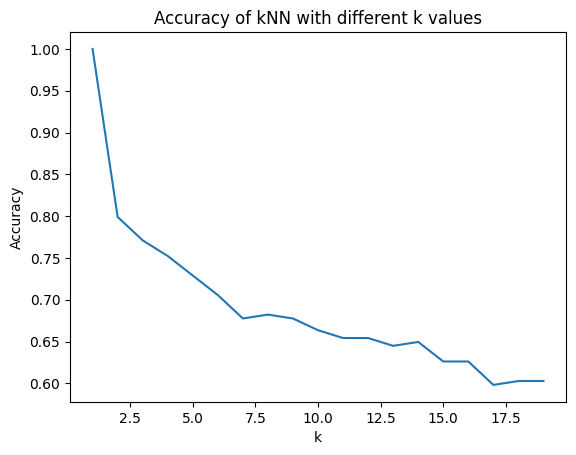

Best KNN = 1


In [883]:
classifiedData = classify_knn(compressed, targets)

mostAccurateKnn = classifiedData[0]
classifiedData = classifiedData[1]

print("Best KNN =", mostAccurateKnn)

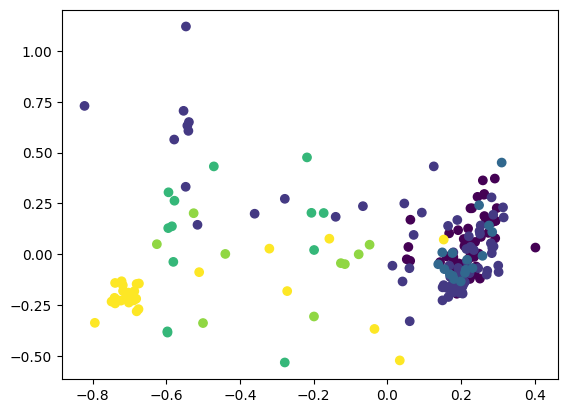

In [884]:
plt.figure()
plt.scatter(compressed[:, 0], compressed[:, 1], c=classifiedData)
plt.show()

In [885]:
# kernel can be "linear", "poly" or "rbf"
# degree can be 2 or 3 on "poly" ONLY
def svm(inputs, targets, kernel: str, degree: int = 0):
    if kernel == "poly":
        classifier = SVC(kernel=kernel, degree=degree)
    else:
        classifier = SVC(kernel=kernel)

    classifier.fit(inputs, targets)

    return classifier.predict(inputs)

In [886]:
def how_good_is_classified_data(classifiedData, targets):
    totalRight = 0
    totalEntries = len(targets)

    for i in range(totalEntries):
        if classifiedData[i] == targets[i]:
            totalRight += 1
    
    return totalRight / totalEntries

In [887]:
def classify_svm(inputs, targets):
    variations = [
        ['Linear', ('linear',)],
        ['RBF', ('rbf',)],
        ['Poly 2°', ('poly', 2)],
        ['Poly 3°', ('poly', 3)]
    ]

    for variation in variations:
        classifiedData = svm(inputs, targets, variation[1][0], variation[1][1] if len(variation[1]) > 1 else 0)
        variation.append(classifiedData)

        # this will be 0.0 = 1.0
        accuracy = how_good_is_classified_data(classifiedData, targets)
        variation.append(accuracy)

    # accuracies type = [title, args, classifiedData, score][]

    plt.figure()
    plt.plot(range(len(variations)), [variation[3] for variation in variations], marker='o')
    plt.xticks(range(len(variations)), [variation[0] for variation in variations])
    plt.xlabel('Type')
    plt.ylabel('Accuracy')
    plt.title("Accuracy of SVM")
    plt.show()

    # this takes the 4th item from the each item in the list and uses it as the key to get the highest acc.
    mostAccurate = max(variations, key=lambda x: x[3])

    return mostAccurate

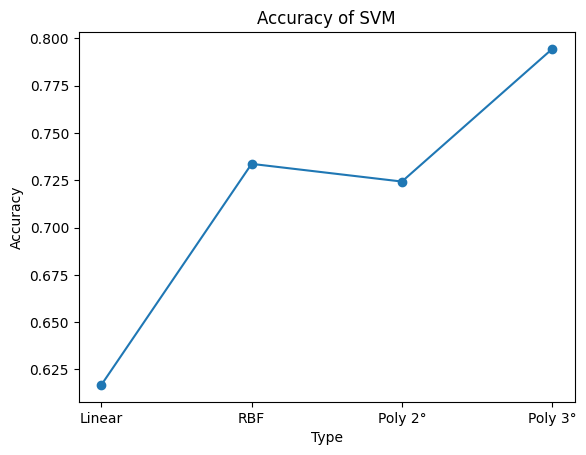

Best SVM = Poly 3° with a score of 0.794392523364486


In [888]:
mostAccurateSvmData = classify_svm(inputs, targets);

mostAccurateSvmTitle = mostAccurateSvmData[0]
mostAccurateSvmArgs = mostAccurateSvmData[1]
mostAccurateSvmScore = mostAccurateSvmData[3]

mostAccurateSvmData = mostAccurateSvmData[2]

print("Best SVM =", mostAccurateSvmTitle, 'with a score of', mostAccurateSvmScore)

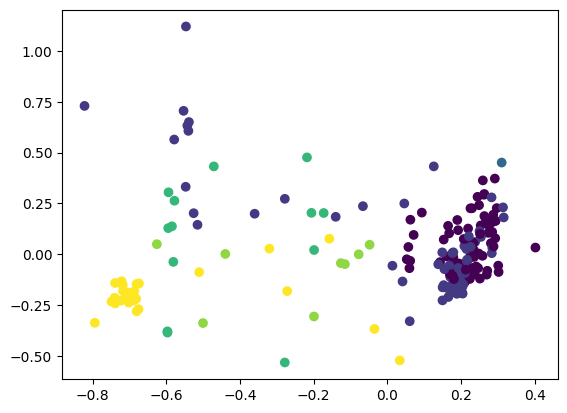

In [889]:
plt.figure()
plt.scatter(compressed[:, 0], compressed[:, 1], c=mostAccurateSvmData)
plt.show()

## 1.3 Assessment of Classification

In [890]:
from sklearn.model_selection import cross_val_score

In [891]:
folds = 10;

In [892]:
def svm_cross_val(inputs, targets, kernel: str, degree: int):
    classifier = SVC(kernel=kernel, degree=degree)

    return cross_val_score(classifier, inputs, targets, cv=folds)

In [893]:
def knn_cross_val(inputs, targets, k: int):
    classifier = KNeighborsClassifier(n_neighbors=k)
    
    return cross_val_score(classifier, inputs, targets, cv=folds)

In [894]:
print("Using KNN Value:", mostAccurateKnn)
print("Using SVM Value(s):", *mostAccurateSvmArgs)

knn_accuracies = knn_cross_val(compressed, targets, mostAccurateKnn)
svm_accuracies = svm_cross_val(inputs, targets, *mostAccurateSvmArgs)

Using KNN Value: 1
Using SVM Value(s): poly 3


/Users/bobbymannino/Code/comp2002-report/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
/Users/bobbymannino/Code/comp2002-report/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


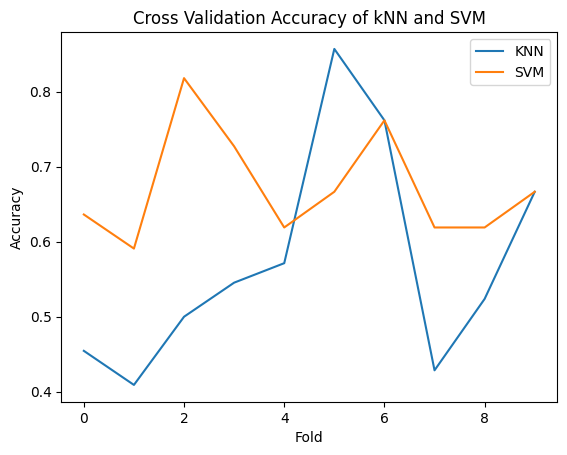

In [895]:
plt.figure()

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title("Cross Validation Accuracy of kNN and SVM")

plt.plot(range(folds), knn_accuracies, label="KNN")
plt.plot(range(folds), svm_accuracies, label="SVM")

plt.legend()
plt.show()

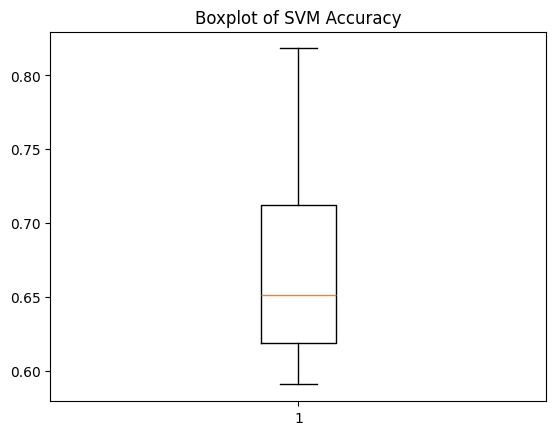

In [896]:
plt.figure()

plt.title("Boxplot of SVM Accuracy")

plt.boxplot(svm_accuracies, label="SVM")

plt.show()

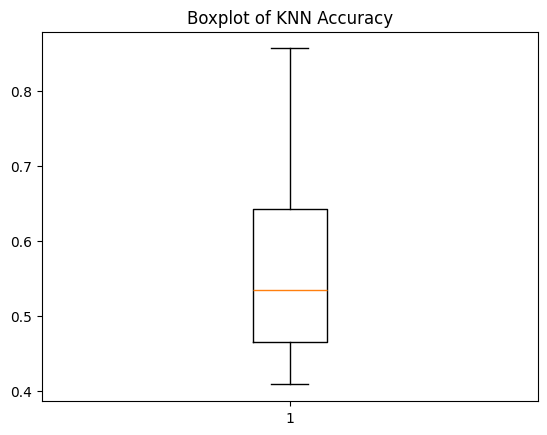

In [897]:
plt.figure()

plt.title("Boxplot of KNN Accuracy")

plt.boxplot(knn_accuracies, label="KNN")

plt.show()

In [898]:
print("KNN Max", max(knn_accuracies))
print("SVM Max", max(svm_accuracies))

KNN Max 0.8571428571428571
SVM Max 0.8181818181818182


In [899]:
print("KNN Avg.", sum(knn_accuracies) / folds)
print("SVM Avg.", sum(svm_accuracies) / folds)

KNN Avg. 0.571861471861472
SVM Avg. 0.6725108225108225


### Summary

After looking at the graph we can see that there is no clear winner, except maybe svm at fold 10, but if we had to pick an average winner it is not clear by the graph. If we look at the 2 blocks below the graph i have made a couple statements to see a numeric representation of the max and average of the scores. In both cases SVM comes out on top so i think to me it is clear which is more accurate, even if its only by 5%.

I am not sure wether this matters or not but it seems that both are highly volotile.

# 2. Optimization

## 2.1 Generation of Random Solutions

In [900]:
from math import sin, cos, exp, pi

In [901]:
def schaffer(x, y):
    top = sin(x**2 - y**2)**2 - 0.5;
    bottom = (1 + 0.001 * (x**2 + y**2))**2

    return 0.5 + (top / bottom);

In [902]:
def modified_schaffer(x, y):
    part1 = 20 * exp(-0.2 * (0.5 * (x**2 + y**2))**0.5);
    part2 = exp(0.5 * cos(2 * pi * x) + cos(2 * pi * y));

    return 20 - part1 - part2;

In [903]:
def easom(x, y):
    return cos(x) * cos(y) * exp(-((x - pi)**2 + (y - pi)**2));

In [904]:
def plot500RandomValues(fn, label: str):
    x = np.random.uniform(-5, 5, 500);
    y = np.random.uniform(-5, 5, 500);

    z = []

    for i in range(len(x)):
        z.append(fn(x[i], y[i]));

    plt.figure();
    plt.scatter(x, y, c=z);
    plt.colorbar();
    plt.title(label);
    plt.show();

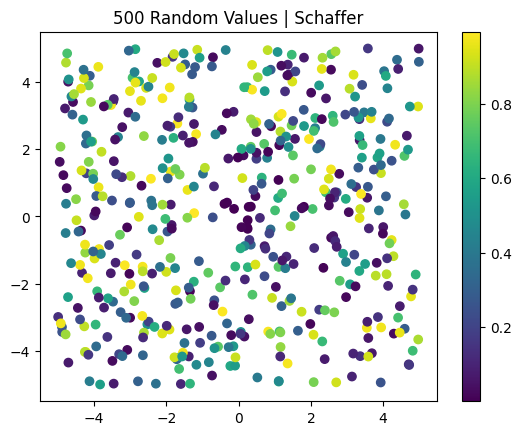

In [905]:
plot500RandomValues(schaffer, '500 Random Values | Schaffer');

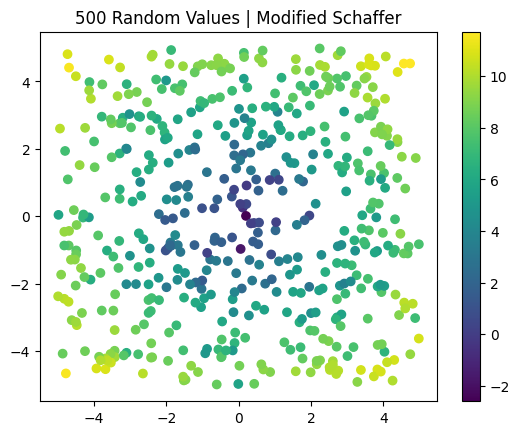

In [906]:
plot500RandomValues(modified_schaffer, '500 Random Values | Modified Schaffer');

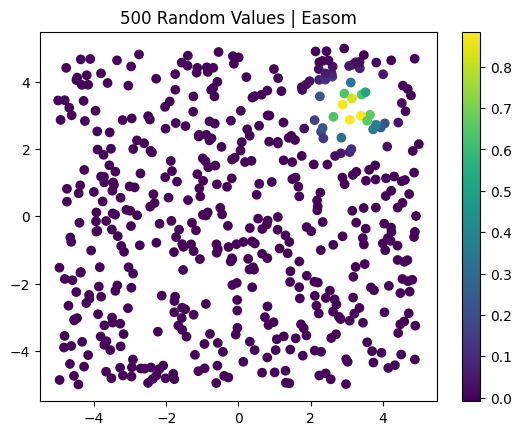

In [907]:
plot500RandomValues(easom, '500 Random Values | Easom');

## 2.2 Algorithm Implementation

In [908]:
type Genome = tuple[float, float];

In [909]:
# The 2 is from the amount of characteristics in a genome, which is 2 (x and y) in this case
CHAR_SIZE = 2;
POP_SIZE = 100;
GENERATIONS = 100;
MUTATION_RATE = 0.1;
MIN_BOUND = -5;
MAX_BOUND = 5;
FITNESS_FUNCTION = schaffer;

In [910]:
def create_genome() -> Genome:
    return np.random.uniform(MIN_BOUND, MAX_BOUND, CHAR_SIZE);

In [911]:
# Creates an array of random genomes
def create_population() -> list[Genome]: 
    return [create_genome() for _ in range(POP_SIZE)];

In [912]:
def fitness(genome: Genome):
    return FITNESS_FUNCTION(*genome)

In [913]:
def mutate(genome: Genome) -> Genome:
    mutation = np.random.normal(0, MUTATION_RATE, CHAR_SIZE);

    return (genome[0] + mutation[0], genome[1] + mutation[1]);

In [914]:
def uniform_crossover(parent1: Genome, parent2: Genome) -> tuple[Genome, Genome]:
    child1, child2 = [], [];

    for i in range(CHAR_SIZE):
        if np.random.rand() < 0.5:
            child1.append(parent1[i]);
            child2.append(parent2[i]);
        else:
            child1.append(parent2[i]);
            child2.append(parent1[i]);

    return (child1, child2);

In [915]:
from random import choices;

In [916]:
def selection(population: list[Genome], fitness_fn) -> list[Genome]:
    return choices(
        population=population,
        weights=[fitness_fn(genome) for genome in population],
        k=2
    );

In [917]:
def evolve():
    # Get initial generation
    population = create_population();

    # A list of (best, worst, average) scores for each generation
    scores: list[tuple[float, float, float]] = [];

    for i in range(GENERATIONS):
        # Sort population by fitness, best first
        population = sorted(population, key=lambda x: fitness(x), reverse=True);

        # Select the best 2 as parents
        next_gen = population[0:2];

        for j in range(int(len(population) / 2) - 1):
            parent1, parent2 = selection(population, fitness);

            child1, child2 = uniform_crossover(parent1, parent2);

            child1 = mutate(child1);
            child2 = mutate(child2);
        
            next_gen.append(child1);
            next_gen.append(child2);

        population = next_gen;

        best = fitness(population[0]);
        worst = fitness(population[-1]);
        average = sum([fitness(genome) for genome in population]) / len(population);

        scores.append((best, worst, average));

    return scores;


In [918]:
scores = evolve();

In [919]:
print('Best generation was No.', scores.index(max(scores, key=lambda x: x[0])), 'with a score of', max(scores, key=lambda x: x[0])[0]);
print('Worst generation was No.', scores.index(min(scores, key=lambda x: x[1])), 'with a score of', min(scores, key=lambda x: x[1])[1]);

Best generation was No. 30 with a score of 0.9984316985060774
Worst generation was No. 1 with a score of 0.16028515749780647


## 2.3 Visualisation of Results

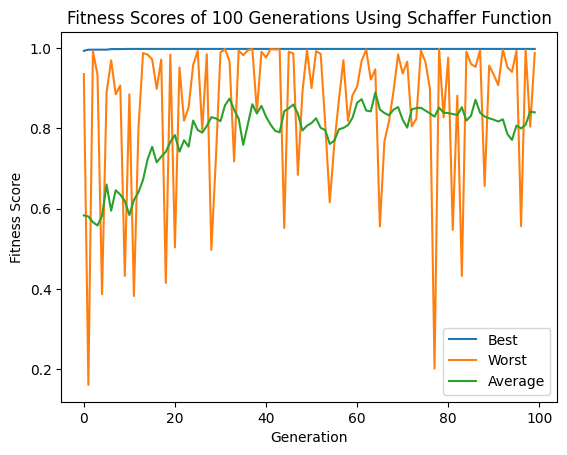

In [920]:
plt.figure();

plt.plot(range(GENERATIONS), [score[0] for score in scores], label='Best');
plt.plot(range(GENERATIONS), [score[1] for score in scores], label='Worst');
plt.plot(range(GENERATIONS), [score[2] for score in scores], label='Average');

plt.xlabel('Generation');
plt.ylabel('Fitness Score');
plt.title('Fitness Scores of ' + str(GENERATIONS) + ' Generations Using Schaffer Function');
plt.legend();

plt.show();